<a href="https://www.kaggle.com/code/junedsarpanch/speech-emotions-recognisation?scriptVersionId=228462040" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Running Model

In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [2]:

# Function to extract features from audio
def extract_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    mfccs_std = np.std(mfccs.T, axis=0)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    chroma_std = np.std(chroma.T, axis=0)

    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_mean = np.mean(mel.T, axis=0)
    mel_std = np.std(mel.T, axis=0)

    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    contrast_mean = np.mean(contrast.T, axis=0)
    contrast_std = np.std(contrast.T, axis=0)

    features = np.hstack((mfccs_mean, mfccs_std, chroma_mean, chroma_std, mel_mean, mel_std, contrast_mean, contrast_std))
    return features


In [3]:
# Function to load and preprocess datasets
def load_data(dataset_path, emotion_mapping):
    X, Y = [], []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                features = extract_features(file_path)
                X.append(features)
                emotion_label = file.split("-")[2]
                Y.append(emotion_mapping.get(emotion_label, "Unknown"))
    return np.array(X), np.array(Y)

# Load both datasets
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio"
tess_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"

emotion_mapping = {
    "01": "Neutral", "02": "Calm", "03": "Happy", "04": "Sad",
    "05": "Angry", "06": "Fearful", "07": "Disgust", "08": "Surprised"
}



In [4]:
# Load data for RAVDESS
X_ravdess, Y_ravdess = load_data(ravdess_path, emotion_mapping)


In [5]:
X_ravdess.shape

(2880, 374)

In [6]:
Y_ravdess.shape

(2880,)

In [7]:

# Load data for TESS and standardize labels
def load_and_preprocess_data_tess(dataset_path):
    X, Y = [], []
    for emotion_folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, emotion_folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(folder_path, file)
                    features = extract_features(file_path)
                    X.append(features)
                    Y.append(emotion_folder)
    return np.array(X), np.array(Y)



In [8]:
X_tess, Y_tess = load_and_preprocess_data_tess(tess_path)



In [9]:
X_tess.shape

(2800, 374)

In [10]:
Y_tess.shape

(2800,)

In [11]:
# Combine datasets
X_combined = np.concatenate((X_ravdess, X_tess), axis=0)
y_combined = np.concatenate((Y_ravdess, Y_tess), axis=0)

In [12]:
X_combined.shape

(5680, 374)

In [13]:
y_combined.shape

(5680,)

In [14]:

# Standardize labels
def standardize_emotion_labels(y_combined):
    emotion_mapping = {
        'Angry': 'angry', 'OAF_angry': 'angry', 'YAF_angry': 'angry',
        'Happy': 'happy', 'OAF_happy': 'happy', 'YAF_happy': 'happy',
        'Sad': 'sad', 'OAF_Sad': 'sad', 'YAF_sad': 'sad',
        'Fearful': 'fear', 'OAF_Fear': 'fear', 'YAF_fear': 'fear',
        'Disgust': 'disgust', 'OAF_disgust': 'disgust', 'YAF_disgust': 'disgust',
        'Neutral': 'neutral', 'OAF_neutral': 'neutral', 'YAF_neutral': 'neutral',
        'Surprised': 'surprise', 'OAF_Pleasant_surprise': 'surprise', 'YAF_pleasant_surprised': 'surprise',
        'Calm': 'calm'
    }
    y_standardized = np.array([emotion_mapping.get(label, label) for label in y_combined])
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_standardized)
    return y_encoded, label_encoder.classes_

y_combined_encoded, class_labels = standardize_emotion_labels(y_combined)



In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined_encoded, test_size=0.2, random_state=42)


In [16]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [17]:
X_train.shape

(4544, 374, 1)

In [18]:
X_test

array([[[-771.59051514],
        [ 100.49775696],
        [  22.60391617],
        ...,
        [   4.24979479],
        [   3.8526866 ],
        [   3.70869744]],

       [[-554.05267334],
        [  47.17851639],
        [ -11.12787819],
        ...,
        [   5.93182103],
        [   4.66724545],
        [   7.49502308]],

       [[-713.60528564],
        [  91.171875  ],
        [  -7.00313568],
        ...,
        [   4.56038741],
        [   3.64700315],
        [   5.69639121]],

       ...,

       [[-469.49850464],
        [  71.30276489],
        [  22.3670826 ],
        ...,
        [   5.12957582],
        [   4.00366246],
        [   2.97487885]],

       [[-695.03546143],
        [  89.54067993],
        [   9.1557703 ],
        ...,
        [   4.29802851],
        [   4.09535649],
        [   5.52290203]],

       [[-340.74731445],
        [   8.35183811],
        [ -13.20048141],
        ...,
        [   8.21526364],
        [   6.7644109 ],
        [   3.35446082]]

In [19]:
# Define CNN model function
def create_model(input_shape, num_classes):
    model = Sequential([
        # First Conv Block - Reduced regularization
        Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),  # Reduced dropout
        
        # Second Conv Block - Reduced regularization
        Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.25),  # Reduced dropout
        
        # Third Conv Block - Reduced regularization
        Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),  # Reduced dropout
        
        # Dense layers - Increased capacity
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),  # Increased units
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),  # Added another dense layer
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    # Increased learning rate slightly
    model.compile(
        optimizer=Adam(learning_rate=0.0003),  # Increased learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [21]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 374, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 374, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 374, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 374, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 187, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 187, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 93, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 93, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │     6,029,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,32

 Total params: 19,642,842 (74.93 MB)

 Trainable params: 6,547,016 (24.97 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 13,094,034 (49.95 MB)

In [1]:

# Training parameters
from tensorflow.keras.callbacks import EarlyStopping
# Training parameters with modifications
num_classes = len(class_labels) 
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

# Modified training parameters
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,  # Increased patience
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as an improvement
)

# Train with modified batch size and more epochs
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,  # Increased epochs
    batch_size=16,  # Reduced batch size for better generalization
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742381437.507725      69 service.cc:145] XLA service 0x7fee300037c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742381437.507785      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1742381448.187677      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


284/284 - 18s - 63ms/step - accuracy: 0.3669 - loss: 2.3380 - val_accuracy: 0.5414 - val_loss: 1.7257
Epoch 2/20
284/284 - 2s - 6ms/step - accuracy: 0.5486 - loss: 1.6747 - val_accuracy: 0.6144 - val_loss: 1.4575
Epoch 3/20
284/284 - 2s - 6ms/step - accuracy: 0.5982 - loss: 1.5399 - val_accuracy: 0.6540 - val_loss: 1.4502
Epoch 4/20
284/284 - 2s - 6ms/step - accuracy: 0.6314 - loss: 1.4552 - val_accuracy: 0.6259 - val_loss: 1.4611
Epoch 5/20
284/284 - 2s - 6ms/step - accuracy: 0.6468 - loss: 1.4137 - val_accuracy: 0.6470 - val_loss: 1.3867
Epoch 6/20
284/284 - 2s - 7ms/step - accuracy: 0.6598 - loss: 1.3686 - val_accuracy: 0.6752 - val_loss: 1.3099
Epoch 7/20
284/284 - 2s - 6ms/step - accuracy: 0.6719 - loss: 1.3544 - val_accuracy: 0.6532 - val_loss: 1.3994
Epoch 8/20
284/284 - 2s - 6ms/step - accuracy: 0.6827 - loss: 1.3043 - val_accuracy: 0.6981 - val_loss: 1.2383
Epoch 9/20
284/284 - 2s - 6ms/step - accuracy: 0.6895 - loss: 1.2817 - val_accuracy: 0.6329 - val_loss: 1.4670
Epoch 10/2

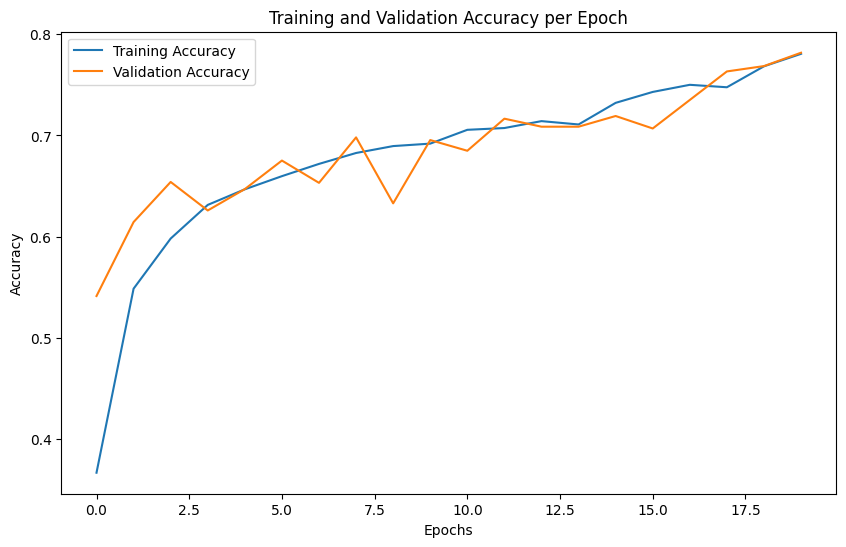

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

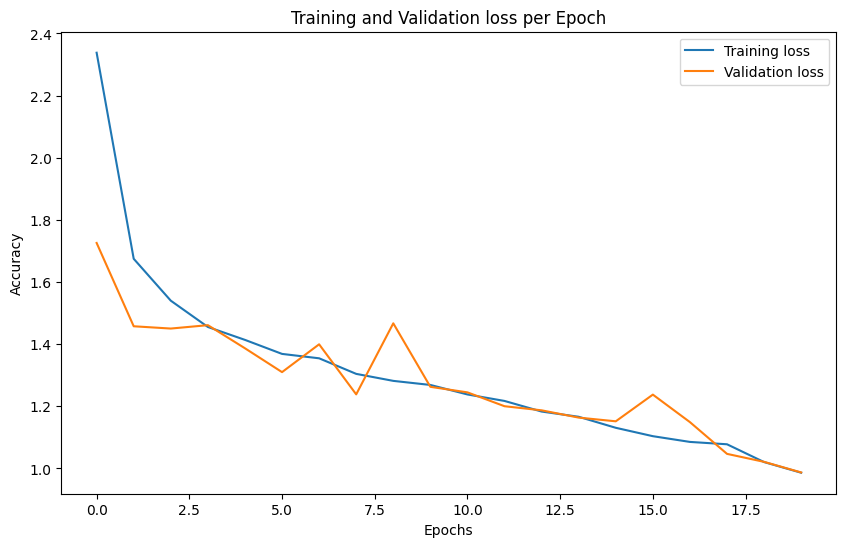

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
# Save the model
model_save_path = "/kaggle/working/emotion_cnn_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/emotion_cnn_model.h5


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 374, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 374, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 374, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 374, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 187, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 187, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 93, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 93, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,029,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 19,642,842 (74.93 MB)

 Trainable params: 6,547,016 (24.97 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 13,094,034 (49.95 MB)

In [6]:
# Load the model for future predictions
loaded_model = load_model("/kaggle/input/saved-model/emotion_cnn_model.h5")

# Function to predict emotion of a new audio file using the loaded model
def predict_emotion(audio_path, model, class_labels):
    features = extract_features(audio_path)
    features = np.expand_dims(features, axis=0)
    features = np.expand_dims(features, axis=2)
    prediction = model.predict(features)
    predicted_label = class_labels[np.argmax(prediction)]
    return predicted_label

# Example usage
new_audio_path = "/kaggle/input/test-sample/Test data sample/03-01-05-01-01-01-03.wav"
predicted_emotion = predict_emotion(new_audio_path, loaded_model, class_labels)
print(f"Predicted emotion for the new audio file: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
Predicted emotion for the new audio file: disgust


In [9]:
import os
import numpy as np
from tensorflow.keras.models import load_model

# Load the model for future predictions
loaded_model = load_model("/kaggle/input/saved-model/emotion_cnn_model.h5")

# Define the class labels (update this to match your model's output classes)
class_labels = ["neutral", "happy", "sad", "angry", "fearful", "disgusted", "surprised"]

# Function to predict emotion of an audio file using the loaded model
def predict_emotion(audio_path, model, class_labels):
    # Assuming extract_features function is defined to get the features of the audio
    features = extract_features(audio_path)
    features = np.expand_dims(features, axis=0)  # Expand dims to add batch dimension
    features = np.expand_dims(features, axis=2)  # Expand dims to match model input shape
    prediction = model.predict(features)
    predicted_label = class_labels[np.argmax(prediction)]
    max_index = np.argmax(prediction)
    print(max_index)
    return predicted_label

# Path to the directory containing multiple audio files
audio_folder = "/kaggle/input/test-sample/Test data sample/"

# Loop through each file in the directory and predict emotion
i=0
for filename in os.listdir(audio_folder):
    if filename.endswith(".wav"):
        audio_path = os.path.join(audio_folder, filename)
        
        # Predict emotion
        predicted_emotion = predict_emotion(audio_path, loaded_model, class_labels)
        print(f"Predicted emotion for {filename}: {predicted_emotion}")
        if(i==4):
            break
        i+=1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
2
Predicted emotion for 03-01-07-01-01-01-22 - Copy.wav: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6
Predicted emotion for 03-01-04-01-01-01-08 - Copy.wav: surprised
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
Predicted emotion for 03-01-05-01-01-01-11 - Copy.wav: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1
Predicted emotion for 03-01-04-01-01-01-13.wav: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0
Predicted emotion for 03-01-05-01-01-01-11.wav: neutral
